In [2]:
#import all dependencies
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns #becuase I like pretty graphs
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

Vacation dates: July 26-August 5

In [3]:
#create our engine from the existing database
engine = create_engine('sqlite:///hawaii.sqlite', echo=False)

In [4]:
#do the automapping stuff
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
#check out the keys
Base.classes.keys()

['measurements', 'stations']

In [6]:
#create classes from the reflected database
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [7]:
#use Session to run our queries
session = Session(engine)

In [8]:
#look at the databases to remember what we have in them
inspector = inspect(engine)
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(20)
date VARCHAR
prcp FLOAT
tobs INTEGER


### Precipitation Analysis

In [9]:
#use datetime to get today's date so we can filter to get the twelve previous months' data
import datetime as dt

In [10]:
year_ago = dt.date.today() - dt.timedelta(days=365)
two_years_ago = year_ago - dt.timedelta(days=730)
year_ago
two_years_ago

datetime.date(2015, 5, 8)

In [11]:
#query the database to get 12 months of rain, summed up by the date
twelve_mo_rain = session.query(Measurement.date, func.sum(Measurement.prcp)).\
    filter(Measurement.date < year_ago, Measurement.date > two_years_ago).\
    group_by(Measurement.date).order_by(Measurement.date).all()

In [12]:
#check our output
print(twelve_mo_rain)

[('2015-05-09', 1.28), ('2015-05-10', 1.32), ('2015-05-11', 0.34), ('2015-05-12', 0.09), ('2015-05-13', 0.02), ('2015-05-14', 1.12), ('2015-05-15', 0.85), ('2015-05-16', 0.36), ('2015-05-17', 0.13), ('2015-05-18', 0.66), ('2015-05-19', 0.02), ('2015-05-20', 0.58), ('2015-05-21', 0.9299999999999999), ('2015-05-22', 0.0), ('2015-05-23', 4.67), ('2015-05-24', 0.0), ('2015-05-25', 0.01), ('2015-05-26', 0.25), ('2015-05-27', 0.64), ('2015-05-28', 3.36), ('2015-05-29', 0.05), ('2015-05-30', 0.17000000000000004), ('2015-05-31', 2.05), ('2015-06-01', 3.12), ('2015-06-02', 0.29000000000000004), ('2015-06-03', 0.01), ('2015-06-04', 2.92), ('2015-06-05', 0.22999999999999998), ('2015-06-06', 0.0), ('2015-06-07', 0.08), ('2015-06-08', 0.46), ('2015-06-09', 0.66), ('2015-06-10', 0.18000000000000002), ('2015-06-11', 0.13), ('2015-06-12', 0.11), ('2015-06-13', 0.01), ('2015-06-14', 0.59), ('2015-06-15', 0.7000000000000001), ('2015-06-16', 1.29), ('2015-06-17', 1.1300000000000001), ('2015-06-18', 1.35)

In [13]:
twelve_df = pd.DataFrame(twelve_mo_rain, columns=['date', 'precipitation'])
#twelve_df.set_index('date', inplace=True)
twelve_df.head()

,date,precipitation
0,2015-05-09,1.28
1,2015-05-10,1.32
2,2015-05-11,0.34
3,2015-05-12,0.09
4,2015-05-13,0.02


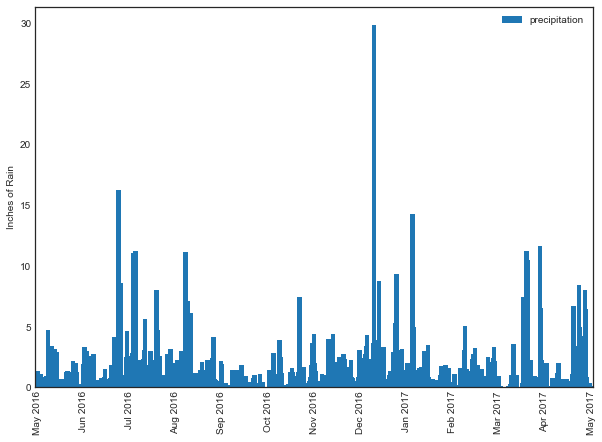

In [14]:
#plot the results
sns.set_style('white')
fig = twelve_df.plot.bar(figsize=(10,7), width=(6))
ticks = (np.arange(0,729,60.74))
months = ['May 2016', 'Jun 2016', 'Jul 2016', 'Aug 2016', 'Sep 2016', 'Oct 2016',
         'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Apr 2017', 'May 2017']
#fig.set_xticklabels(months)
#twelve_df.plot.bar(figsize=(10,7))
#plt.tight_layout()
#fig.xaxis.set_major_locator(plt.LinearLocator(10, 30))
plt.xticks(ticks, months)
plt.ylabel('Inches of Rain')
plt.show()

#note: the exercise says to set the date as the index for the dataframe to plot. When doing this,
#I could not then reduce the number of labels. The plot was flooded with xtick labels.
#Therefore, I kept date as a dataframe column, and then hard coded the x labels as the relevant months.
# I realize this is not ideal but after two hours of struggle could not figure out any other way to
#get the xtick labels looking even marginally ok. PLUS, if you look at the example graph given in the
#homework, even that graph has funky dates: they aren't in sequntial order (and at least mine are.)

In [ ]:
twelve_df.set_index('date', inplace=True)

C:\Users\Aaron\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


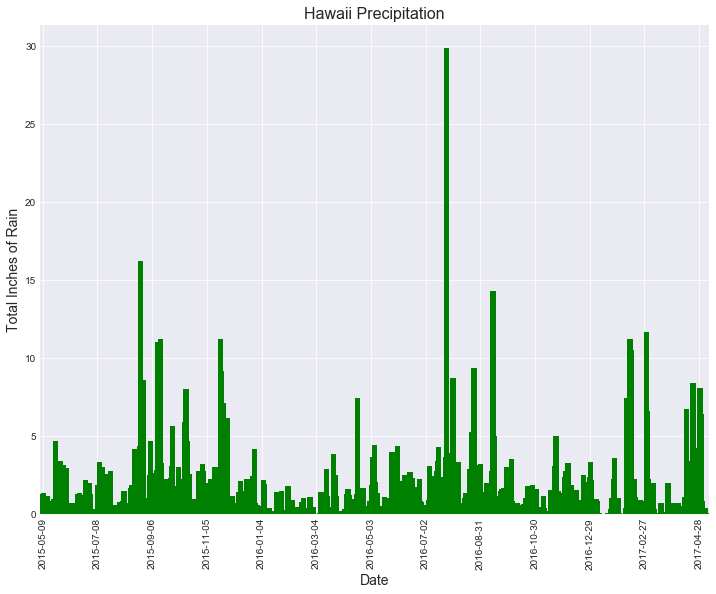

In [55]:
#plotting with the code linked to by Anna for limiting the number of ticks:
sns.set_style('darkgrid')
n=60

ax=twelve_df.plot(kind='bar', figsize=(12,9), width=(6), facecolor='green')
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])
plt.ylabel('Total Inches of Rain', size='14')
plt.xlabel('Date', size='14')
plt.title('Hawaii Precipitation', size='16')
ax.legend().set_visible(False) #removing legend since it's pretty much redundant with the axes labels.
ax.figure.show()

In [25]:
#Use Pandas to print summary statistics for the precipitation data
twelve_df.describe(include='all')

,precipitation
count,729.000000
mean,1.181015
std,2.162121
min,0.000000
25%,0.080000
50%,0.460000
75%,1.370000
max,29.850000


### STATION ANALYSIS

In [26]:
#find the number of stations
number_stations = session.query(func.count(Station.station)).one()
number_stations[0]
print(f"The total number of stations is {number_stations[0]}.")

The total number of stations is 9.


In [27]:
#find the 
activity = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
most_active = session.query(Measurement.tobs).\
    filter(Measurement.date < year_ago, Measurement.date > two_years_ago).\
    filter(Measurement.station == 'USC00519281').all()

In [29]:
most_active
most_active = list(np.ravel(most_active))
len(most_active)

728

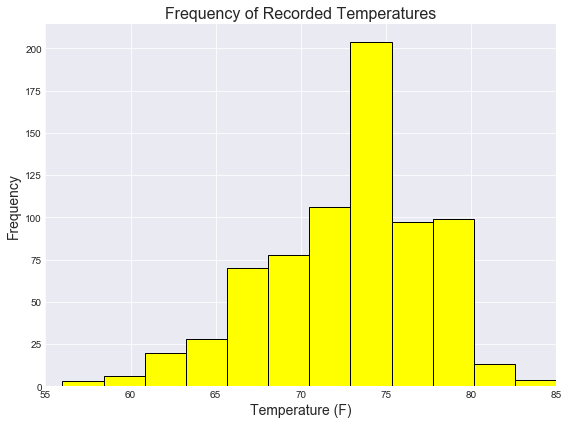

In [54]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(most_active, 12, facecolor='yellow', edgecolor='black')
ax.plot()
ax.set_ylabel('Frequency', size='14')
ax.set_xlabel('Temperature (F)', size='14')
ax.set_title('Frequency of Recorded Temperatures', size='16')
ax.set_xlim(55,85)
fig.tight_layout()
plt.show()

### Temperature Analysis

In [48]:
from datetime import datetime

In [49]:
def calc_temps(start, end):
    start_time = datetime.strptime(start, '%Y-%m-%d')
    end_time = datetime.strptime(end, '%Y-%m-%d')
    temps = session.query(func.min(Measurement.tobs), \
                          func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_time-dt.timedelta(days=365), \
                   Measurement.date <= end_time-dt.timedelta(days=365)).all()
    return temps

In [50]:
data = calc_temps('2018-07-27', '2018-08-05')
data = list(np.ravel(data))
data

[72.0, 79.11363636363636, 84.0]

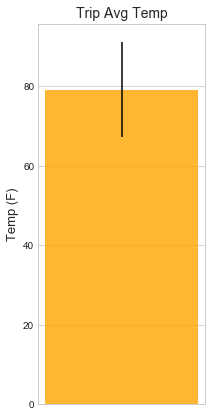

In [58]:
sns.set_style('whitegrid')
plt.figure(figsize=(3,7))
xticks = ()
plt.bar(0, data[1], yerr=(data[2]-data[0]), alpha=0.8, color='orange')
plt.xticks(xticks)
plt.ylabel('Temp (F)', size='13')
plt.title('Trip Avg Temp', size='14')
plt.show()